In [ ]:
#import all the necessary packages
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import imageio.v2 as imageio
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
input_path = '/content/drive/My Drive/AMLProject/Data/2024-flame-ai-challenge/dataset'
output_path = '/content/drive/My Drive/AMLProject/Data/2024-flame-ai-challenge'

train_df = pd.read_csv(os.path.join(input_path,'train.csv'))
train_df.head()

,id,u,alpha,Nt,Nx,Ny,theta_filename,ustar_filename,xi_filename
0,804025,2,10,150,113,32,theta_K_id804025.dat,ustar_ms-1_id804025.dat,xi_id804025.dat
1,875935,2,5,150,113,32,theta_K_id875935.dat,ustar_ms-1_id875935.dat,xi_id875935.dat
2,930086,6,0,150,113,32,theta_K_id930086.dat,ustar_ms-1_id930086.dat,xi_id930086.dat
3,661713,4,5,150,113,32,theta_K_id661713.dat,ustar_ms-1_id661713.dat,xi_id661713.dat
4,633229,2,0,150,113,32,theta_K_id633229.dat,ustar_ms-1_id633229.dat,xi_id633229.dat


In [ ]:
#wind speed (ustar), temperature (theta), and fire-line location (xi)
#To describe each case globally, we are also providing information about the slope (alpha)
#and mean wind speed (u10) -- both being scalar values, and are commonly used in the wildfire community to parameterize wildfire-spread behavior.
#id - file id
#u - wind speed
#alpha - terrain slope
#The following code block was taken from the starter notebook given along with the FLAME AI Challenge
def load_dataX(idx):
    csv_file = train_df.reset_index().to_dict(orient='list')
    dir_path = os.path.join(input_path, "train")
    id = csv_file['id'][idx]
    nt, Nx, Ny = csv_file['Nt'][idx], csv_file['Nx'][idx], csv_file['Ny'][idx]
    theta = np.fromfile(os.path.join(dir_path, csv_file['theta_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, csv_file['ustar_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, csv_file['xi_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    uin  = csv_file['u'][idx]
    alpha = csv_file['alpha'][idx]

    return theta, ustar, xi_f, uin, alpha

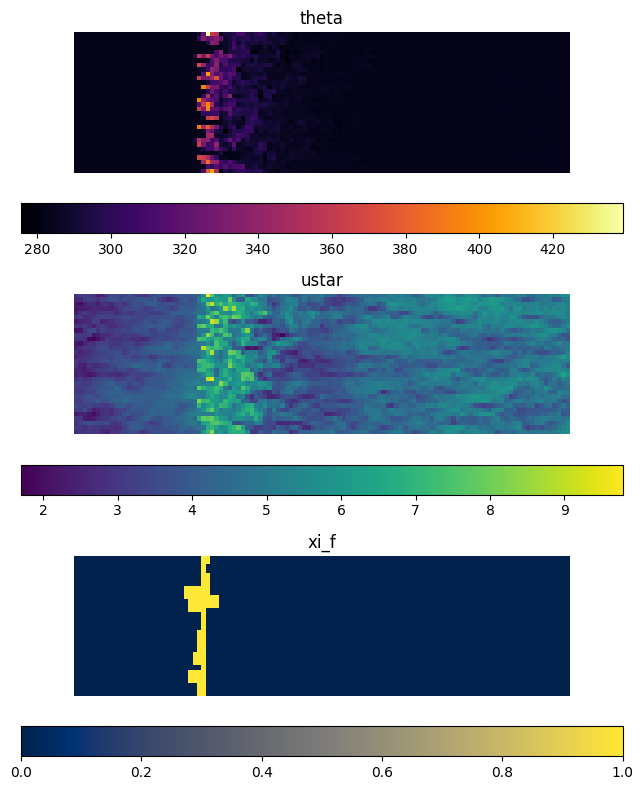

In [ ]:
#The following code block was taken from the starter notebook given along with the FLAME AI Challenge
frame = 50
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
im0 = axs[0].imshow(theta[frame].T, cmap='inferno')
axs[0].set_title('theta')
cbar = fig.colorbar(im0, ax=axs[0], orientation='horizontal')

im1 = axs[1].imshow(ustar[frame].T, cmap='viridis')
axs[1].set_title('ustar')
cbar = fig.colorbar(im1, ax = axs[1], orientation='horizontal')

im2 = axs[2].imshow(xi_f[frame].T, vmin=0, vmax=1, cmap='cividis')
axs[2].set_title('xi_f')
cbar = fig.colorbar(im2, ax=axs[2], orientation='horizontal')
for ax in axs:
    ax.axis('off')
fig.tight_layout()

XG Boost

In [ ]:
#perplexity was used in this code block
def prepare_data(scenario, text,lookback=5, forecast=1):
    ustar = load_2d_data(text+scenario['ustar_filename'], scenario['Nx'], scenario['Ny'], 150)
    theta = load_2d_data(text+scenario['theta_filename'], scenario['Nx'], scenario['Ny'], 150)
    xi = load_2d_data(text+scenario['xi_filename'], scenario['Nx'], scenario['Ny'], 150)

    features = []
    targets = []

    for t in range(lookback, 150 - forecast):
        # Flatten and concatenate the lookback period data
        feature = np.concatenate([
            ustar[t-lookback:t].flatten(),
            theta[t-lookback:t].flatten(),
            xi[t-lookback:t].flatten(),
            [scenario['alpha'], scenario['u']]  # Add slope and mean wind speed
        ])

        # Target is the flattened fire location for the next 'forecast' timesteps
        target = xi[t:t+forecast].flatten()

        features.append(feature)
        targets.append(target)

    return np.array(features), np.array(targets)

In [ ]:
def load_2d_data(filename, nx, ny, nt):
    return np.fromfile(filename, dtype=np.float32).reshape(nt, nx, ny)

In [ ]:
# Prepare data for all 9 scenarios
from sklearn.model_selection import train_test_split
X, y = [], []
for _, scenario in train_df.iterrows():
    text = input_path+'/train/'
    X_scenario, y_scenario = prepare_data(scenario,text)
    X.append(X_scenario)
    y.append(y_scenario)

X = np.vstack(X)
y = np.vstack(y)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train[0])

54242

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=4,
    learning_rate=0.3,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

# Create evaluation set
eval_set = [(X_train, y_train)]

# Fit with eval_set and verbose
model.fit(X_train, y_train,
          eval_set=eval_set,
          verbose=True)

[0]	validation_0-logloss:0.12746
[1]	validation_0-logloss:0.09450
[2]	validation_0-logloss:0.07137
[3]	validation_0-logloss:0.05467


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Calculate training error
from sklearn.metrics import mean_squared_error
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate testing error
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.6f}")
print(f"Testing MSE: {test_mse:.6f}")

Training MSE: 0.005601
Testing MSE: 0.014543


In [ ]:
#Perplexity was used in the following code block
def predict_next_20(model, initial_data, scenario):
    predictions = []

    # Extract u and alpha (assumed to be the last two elements of initial_data)
    static_params = initial_data[-2:]  # u and alpha
    input_data = initial_data[:-2].copy()  # Exclude u and alpha for rolling updates

    for _ in range(20):
        # Reattach static parameters before prediction
        combined_input = np.concatenate([input_data, static_params])
        next_pred = model.predict(combined_input.reshape(1, -1)).flatten()
        predictions.append(next_pred)

        # Update input_data (excluding static parameters)
        update_size = next_pred.size
        input_data = np.roll(input_data, -update_size)
        input_data[-update_size:] = next_pred  # Insert new prediction values

    return np.array(predictions).squeeze()  # Flatten the array to match actual targets


In [ ]:
total_mse = 0
num_samples = len(X_test)

for i in range(num_samples):
    initial_data = X_test[i]
    actual_targets = y_test[i:i + 20]

    # Skip if actual_targets length is not 20
    if len(actual_targets) != 20:
        continue

    predicted_targets = predict_next_20(model, initial_data, scenario)
    mse_per_sample = mean_squared_error(actual_targets, predicted_targets)
    total_mse += mse_per_sample

average_mse = total_mse / num_samples
print(f"Average MSE over 20 timestamps: {average_mse:.6f}")


Average MSE over 20 timestamps: 0.025727
